# 0. Overview

### Data

We will be analyzing an extract of 1994 U.S. Census data. See more on the data set [here](https://archive.ics.uci.edu/ml/datasets/census+income). First, we are going to need some help from some well-known, third-party libraries

### Goals

Work through the given data - cleaning it, exploring it, transforming it - so as to come to a point where we can build a model to predict whether or not a given citizen, based on the other available information, earns over $50K per year. Additionally, we will dive into learning the proper protocols for setting up for tuning, and evaluating, our predictive models. 

### Third-party libraries

Third-party libraries are libraries (collections of code) that do not come with the core Python distribution. You can get these libraries through downloading the Anaconda distribution, which includes them all, or through installing them manually with `pip` (or `pip3`, depending on your system), which is the Python package manager.

When importing a Python library, you can give it an alias, which is usually done to make something easier to type. It's good to follow standard protocol for a given library when doing this so that other people will recognize it throughout your code. 

`numpy` (typically abbreviated as `np`) provides the following:
- a homogenous (read: for a single data type) array with very useful manipulation methods
- a number of useful advanced math functions
- other data type helpers
- in many ways `numpy` is a collection of Python wrappers for very well-optimized C and FORTRAN math code

`pandas` (typically abbreviated as `pd`) is:
- a library that provides, amongst other things, a very nice data structure known as the `DataFrame`
- the `DataFrame` is a relational / tabular data structure
- i.e. it allows you to do SQL-ish analysis in Python
- it also visualizes nicely in Jupyter notebooks
- a good bit of Pandas is actually just user-friendly interfaces on top of `numpy`

`matplotlib` (from which the `pyplot` submodule is typically imported and aliased as `plt`)
- the old faithful data visualization library for Python
- it definitely provides a steep learning curve
- but it's a powerful tool once learned

I've also imported `indoorplants`, a library I've written to help me in my analysis workflows. You are welcome to check out, and _use_ the code, which you can find [here](https://github.com/lermana/indoorplants). Editor's note: this library is still being developed ... in other words, your mileage may vary. If you would like to make use of my code in the seminar, you should click the aforermentioned link, and go ahead and `git clone` that repo, and then follow the brief installation instructions there. Otherwise, you can simply comment out the lines that mention that repo with a `#` (there aren't that many).

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, chi2
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, make_scorer

from indoorplants.analysis import exploratory, wrangle
from indoorplants.validation import crossvalidate, curves

### Taking notes in a `jupyter notebook`

The ability to intertermix well-formatted notes with your code and charts is one of the strongest features that `jupyer` offers its users. You can write notes with [markdown syntax](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). Below is a an example markdown cell, which you can `enter` into to see how its formatting is created: 

**Example note taking**:
> Here is a *quote* 

We can write `code`, too:
```
def fake_func():
    return None
```

You can write math, too:
> $\sum n$

Here's a [link](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to more examples.

### Plots

In [3]:
%matplotlib inline

The above is a _magic_ Jupyter command that ensures all `matplotlib` plots will by default show in the notebook.

# 1. Get Data

### Retrieve and quick look

In [4]:
def get_census_data():
    # column names
    cols = ['age', 'workclass', 'fnlwgt', 'education', 
            'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain',
            'capital_loss', 'hours_per_week', 'native_country', 
            'over_fifty_k']
    
    # url to retrieve data from
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    
    # iterate through lines of data stream, decoding and splitting each line on commas
    with requests.get(url, stream=True) as r:
        results = [l.decode().split(',') for l in r.iter_lines()]
    
    # convert data from of list of lists to DataFrame, set columns, and return
    return pd.DataFrame(results, columns=cols)

Let's use the above function to retrieve our data:

In [5]:
table = get_census_data()

A great first step is to check out the size of your data:

In [6]:
table.shape

(32562, 15)

Next, let's look at data types. We can call the `dtypes` attribute on our `DataFrame` to see the data type for each of its columns. We'll then pass those results into the `value_counts` method, which returns all the values in the column it's called on, with the number of times that each value shows up in the column:

In [7]:
table.dtypes.value_counts()

object    15
dtype: int64

All data columns are currently formatted as _strings_ (which `pandas` represents with the `object` type), which we will have to handle accordingly. 

Let's actually _look_ quickly at the top and bottom of the table. We can do this through using `iloc`, which takes the _integer location_ of rows and columns to return:

In [8]:
table.iloc[:5, :7]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty


In [9]:
table.iloc[-5:, 8:]

,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
32557,White,Male,0,0,40,United-States,>50K
32558,White,Female,0,0,40,United-States,<=50K
32559,White,Male,0,0,20,United-States,<=50K
32560,White,Female,15024,0,40,United-States,>50K
32561,None,None,None,None,None,None,None


### Data cleanliness

Let's check for missing values:

In [10]:
table.isnull().sum()

age               0
workclass         1
fnlwgt            1
education         1
education_num     1
marital_status    1
occupation        1
relationship      1
race              1
sex               1
capital_gain      1
capital_loss      1
hours_per_week    1
native_country    1
over_fifty_k      1
dtype: int64

`isnull()` is a method that returns `True` for every row in `data` that is `null`, in each of the columns. We can then call `sum` on the results to see the total number of `null` values in each column.

We see that we have 1 missing value each, for every column except for `age` - let's see if these all these values are in the same row:

In [11]:
table[table.isnull().any(1)].index

Int64Index([32561], dtype='int64')

One of the ways in which we can filter a `DataFrame` is to pass a condition into it using square brackets.The square bracket syntax works such that it will then return the rows in the `DataFrame` that have a value of `True`. So, `isnull` returns a whole collection of `True` or `False` values for each position in the index, and the square bracket syntax then returns the rest of the row for each `True` index value. 

All missing values are in the row _labeled_ `32561`. Before we delete this row, let's see if the `age` column has any useful information in this row:

In [12]:
table.loc[32561, "age"]

''

Nothing - so let's drop. Note that dropping missing data is, generally speaking a bad idea. In this case, we have exactly _one_ out of over 30K+ rows that's missing, so, fine to just drop it. See more on the subject [here](http://www.stat.columbia.edu/~gelman/arm/missing.pdf).

In [13]:
table = table.drop(32561)

Now, let's check for duplicates:

In [14]:
table.duplicated().sum()

24

The `duplicated` method works similarly to `isnull`, in that it returns a _boolean mask_. By default, it will return `True` for a row that has _already_ been seen. You can control whether it treats the _first_ or _last_ instance of a row as a duplicate, or you can also count _all_ instances of a given row (that appears more than once) as duplicates. This behavior is controlled through the `keep` _keyword argument_. 

Let's write _all_ duplicates to file before we drop them. We can do this using the `to_csv` method, which takes (in addition to other optional parameters that control things like the delimiter used) a _path_ to write the file to:

In [15]:
table[table.duplicated(keep=False)].to_csv("duplicates.csv")

### Data type handling - _numeric_

Let's get this data typed properly. We may have to manually make these changes using the `astype` method, but let's see what the `infer_objects` method can do for us:

In [16]:
table.infer_objects().dtypes

age               object
workclass         object
fnlwgt            object
education         object
education_num     object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain      object
capital_loss      object
hours_per_week    object
native_country    object
over_fifty_k      object
dtype: object

Ok .... nothing. We'll try this manually.

We know that most of these columns contain _categorical_, or _non-numeric_ data, but a few of these are numeric. Let's take a closer look. 

Note that we can pass multiple columns to a `DataFrame` through the use of double brackets. Also note that we can use the `head` method to return the first five rows across all columns:

In [17]:
table[["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


Let's save these columns for future use:

In [18]:
numeric_cols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

It would be good to know whether we have _integer_ or _real_ number data in these numeric columns. How about we see if any of these columns _contain_ a `.`? `pandas` provides classic, Python string functionality to be applied to a `Series` of `object` type through accessing the `str` attribute, which we can make use of here.

A `Series` is a single column of a `DataFrame`. While there is _a lot_ of overlap between `DataFrame` and `Series` functionality, there are some differences, and we are seeing one here - the `str` attribute exists only at the column level; i.e. it doesn't exist across more than one column at a time, if that makes sense.

Let's start by checking our first numeric column to see whether there is a `.` in any of its values:

In [19]:
table[numeric_cols[0]].str.contains("\.").sum()

0

A couple of things to note here:
- you cannot use `table.column`, and must use `table[column]`, when accessing a `DataFrame` column via a variable name
- you must _escape_ `.` with a backslash (othwerise it will be treated as a _regex_ pattern)

### Problem

Check this across _all_ of our `numeric_cols`, through leveraging _iteration_. Bonus points if you can write this check as a one-liner.

In [20]:
[(col, table[col].str.contains("\.").sum()) for col in numeric_cols]

[('age', 0),
 ('fnlwgt', 0),
 ('education_num', 0),
 ('capital_gain', 0),
 ('capital_loss', 0),
 ('hours_per_week', 0)]

In [21]:
table[numeric_cols] = table[numeric_cols].astype(int)

Also, please note that if you try to convert a string of a decimal-numbered nature to an `int`, you'll likely get an error. I thought this was a fun exercise, though!

In [22]:
# int("4.5")

### Data type handling - _boolean_

Let's take a closer look at what we're trying to predict - `over_fifty_k`:

In [23]:
table.over_fifty_k.head()

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: over_fifty_k, dtype: object

This doesn't look very nice, does it?

In [24]:
table.over_fifty_k.value_counts()

 <=50K    24720
 >50K      7841
Name: over_fifty_k, dtype: int64

So, this is really a `bool` variable, but we currently have it represented via this _ugly_ string. Let's fix that.

### Problem

Reingineer this as a `bool` column.

In [25]:
table.over_fifty_k.value_counts()

 <=50K    24720
 >50K      7841
Name: over_fifty_k, dtype: int64

Here, we can make use of the `apply` method, which comes in handy when you want to run some functionality on a `DataFrame` or `Series` that doesn't come built-in as a method.

In this case, I'll pass it an _anonymous_ function, or a function that isn't formally defined with a name, and I'll do this using the `lambda` keyword:

In [26]:
table.over_fifty_k.apply(lambda val: 1 if val == '>50K'else 0).value_counts()

0    32561
Name: over_fifty_k, dtype: int64

Uh oh .. what happened?! you didn't overwrite the original column with that, did you? Restarts notebook...

Let's take a closer look at `over_fifty_k`. We can see all _unique_ values in the `Series` with the `unique` method:

In [27]:
table.over_fifty_k.unique()

array([' <=50K', ' >50K'], dtype=object)

Ahh, makes sense now ... right? We have some leading spaces around our variables that we'll have to take care of if we want to be able to make sense of this data. Let me now take a moment to say to you: welcome to "data science" :)

We can take a cue from our previous handling of some of our `object` columns to solve this one:

In [28]:
table.over_fifty_k = table.over_fifty_k.str.strip()

In [29]:
table.over_fifty_k.apply(lambda _: True if _ == '>50K'else False).value_counts(normalize=True)

False    0.75919
True     0.24081
Name: over_fifty_k, dtype: float64

Much better. Note that we made use of the `normalize` _kwarg_ (short for _keyword argument_) to return _relative_ as opposed to _absolute_ value counts.

In [30]:
table.over_fifty_k = table.over_fifty_k.apply(lambda _: True if _ == '>50K'else False)

### Data type handling - almost done

Let's take a look at what we've done so far:

In [31]:
table.dtypes.value_counts()

object    8
int64     6
bool      1
dtype: int64

We can actually make sub-selections on our table, by `dtype`:

In [32]:
table.select_dtypes(include=[int]).head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


Wait... before we progress - should we check all the other `object` columns to make sure they don't have the same issue as `over_fifty_k` did?

### Problem

Check whether other `object` column values have issues with trailing and / or leading spaces, and try to make use of iteration and / or group selection.

Let's take a look at this `object` data:

In [33]:
table.select_dtypes(include=[object]).head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


Now we can iterate through these columns as we did with the numeric columns, checking to see if any contain a space:

In [34]:
[(col, table[col].str.contains(" ").sum()) 
 for col in table.select_dtypes(include=[object]).columns]

[('workclass', 32561),
 ('education', 32561),
 ('marital_status', 32561),
 ('occupation', 32561),
 ('relationship', 32561),
 ('race', 32561),
 ('sex', 32561),
 ('native_country', 32561)]

We can see that _every_ row in the table, in these columns, contains a space - no bueno! But we do not know _where_ in each string value these spaces are occurring. I.e. these could be trailing or leading spaces (bad) or spaces that make up a part of the value (which we would _not_ want to alter - at least not _now_). 

Luckily for us, the `strip` method will just remove trailing and leading spaces. So we can run this without fear of altering the internals of any of our string values:

In [35]:
for col in table.select_dtypes(include=[object]).columns:
    table[col] = table[col].str.strip()

Let's see if there are any remaining spaces:

In [36]:
[(col, table[col].str.contains(" ").sum()) 
 for col in table.select_dtypes(include=[object]).columns]

[('workclass', 0),
 ('education', 0),
 ('marital_status', 0),
 ('occupation', 0),
 ('relationship', 0),
 ('race', 0),
 ('sex', 0),
 ('native_country', 0)]

That did the trick!

# 2. Exploratory Data Analysis

Exploratory data analysis (EDA) is key to understanding your data - this is where you poke around and see how things work.

### Numeric columns - _distributional analysis_

With numeric data, we often want to understand how it's _distributed_, i.e. the frequencies associated with different values in the data.

Let's start with `age`. We can see the number of unique values with the `nunique` method:

In [37]:
table.age.nunique()

73

We have a good number of values here, but this is still _discrete_ data, so we can actually use `value_counts` to analyze it.

In the following cell, we're going to go into `table`, get the `age` column, call `value_counts`, sort the index with the `sort_index` method (so that the ages are presented in _numerical_ order, as opposed order of frequency, which is how `value_counts` will return its results) and then we're going to call `plot`.

You can call (i.e. put parantheses after the function name) `plot` directly, which will produce a _line_ plot, or you can specify other types of plots. In this case, we're calling the `bar` method, which will give us a _bar graph_. I've passed some additional arguments to `bar` to control the _size_ of the figure, as well as the _color_ of the plot, and, finally, the rotation of the _x-axis_ labels.

The results of this procedure are the _axes_ of the plot, which can be used to further modify the plot. I'm using these _axes_ (stored in the variable `ax`) to set a title.

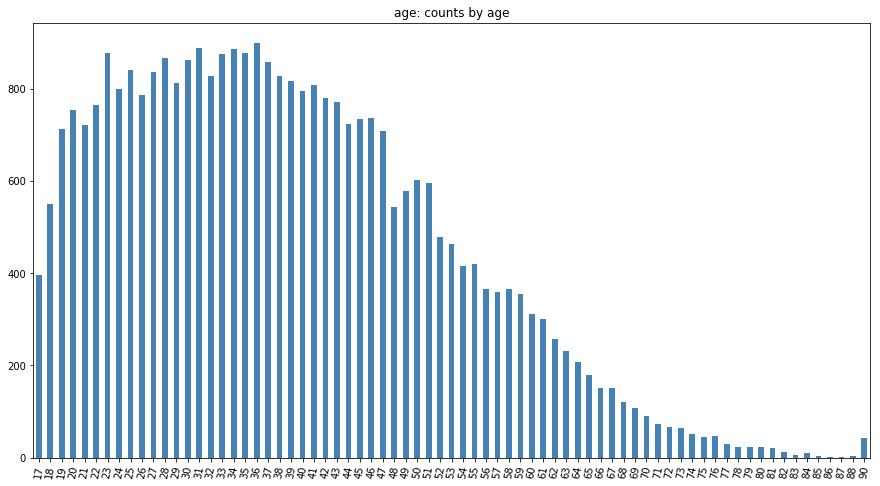

In [38]:
ax = table.age.value_counts().sort_index().plot.bar(figsize=(15, 8), color="steelblue", rot=80)
ax.title.set_text('age: counts by age')

They say a picture's worth a thousand words, and I think that adage undoubtedly holds true in data analysis.

Right off the bat, we can see here that there's an unusual spike at 90, which could indicate that all ages greater than or equal to 90 were simply bucketed.Additionally, we can that the 30s are probably the most well-represented decade in this data. 

Let's put some numbers behind these observations.

In [39]:
table.age.describe()

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

The `describe` method gives us a number of descriptive stats. In order of appearance:
- number of non-null rows
- mean
- standard deviation
- minumum value in the data
- 25th percentile
- median
- 75th percentile
- maximum value in the data

Note that you can also call these functions individually:

In [40]:
table.age.mean()

38.58164675532078

We can see that the average age (noting that this is not a _true_ average, due to binning at 90) is around 39. The fact that the median is a little bit lower than the average is a nod to this data's _positive- or right-skew_. We can also see that this data goes neither below 17 nor above 90.

`matploliblib` is a very powerful, if difficult-to-learn, tool. A deep dive into its functionality is outside the scope of this seminar, but to give you a sense of what it can do:

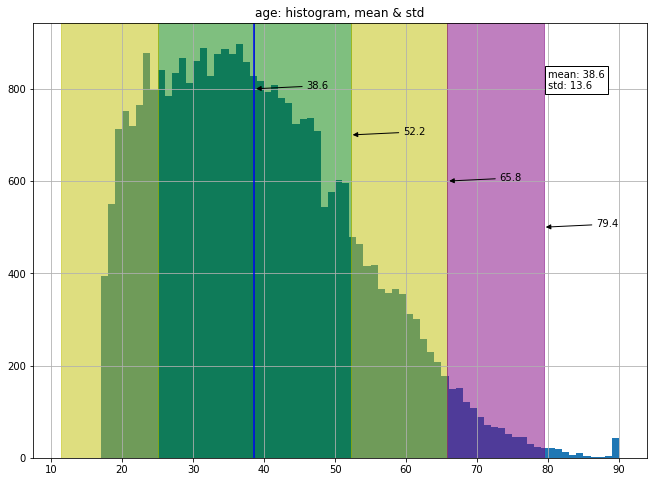

In [41]:
ax = exploratory.center_scale_plot(table.age, np.mean, np.std, bins=73)

This is interesting data, as it's got a hard cutoff at 17. Sometimes, when we see data that is very skewed, it can be helpful to take a transform of it. Taking the _logarithm_ of data will strongly reduce data. The _square root_ will reduce skew more gently. The _cube root_ transform works well when dealing with negative values.

Let's try the `log` function from `numpy`:

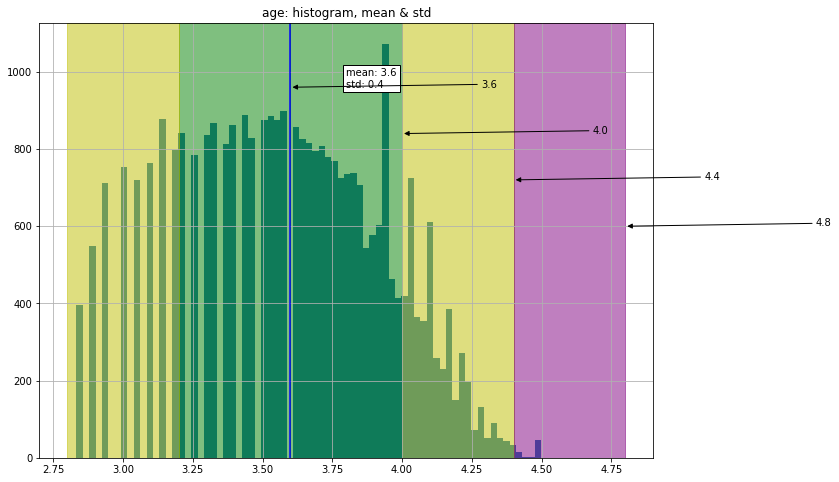

In [42]:
ax = exploratory.center_scale_plot(np.log(table.age), np.mean, np.std, bins=73)

I don't know that we'll need this column, but let's go ahead and retain it anyway. Note that when creating a _new_ column, you must use the `table["column_name"]` notation and _not_ `table.column_name` notation:

In [43]:
table["age_log"] = np.log(table.age)

Let's take a look at a continuous column, `capital_gain`. We will do this through plotting a _histogram_, which we can do through the `DataFrame`'s `hist` method. Similar to before, I will set figure size, color, and a title. I will also tell it how many _bins_ to create.

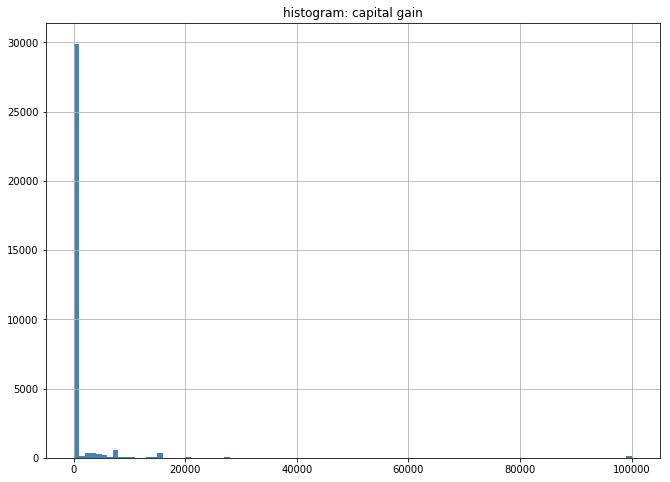

In [44]:
ax = table.capital_gain.hist(figsize=(11, 8), color="steelblue", bins=100)
ax.title.set_text("histogram: capital gain")

Wowza! How many people in this data set even have a non-zero capital_gain?

In [45]:
(table.capital_gain > 0).sum()

2712

So, less than 10% of the data. I wonder if a similar situation exists for `capital_loss`?

### Problem

Determine the percentage of people in the data who have a non-zero value for `capital_loss`.

Then, confirm whether or not there is overlap between `capital_gain` and `capital_loss`. Hint: to check multiple conditions, each must be wrapped in its own set of paranetheses; you can use `|` for _or_ and `&` for _and_, depending on how you'd like to structure the conditions.

Next, create a new column, `capital_gain_net`, that combines the values in `capital_gain` and `capital_loss`. Visualize the results and do a quick write-up on what you have found. Feel free to home in on particular sections of the chart. 

In [46]:
table.capital_loss.describe()

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64

If we wanted a nicer view of these results, we could convert this `Series` to a `DataFrame`:

In [47]:
table.capital_loss.describe().to_frame()

,capital_loss
count,32561.000000
mean,87.303830
std,402.960219
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4356.000000


If for some reason we wanted a row-wise view of these results, we could then _transpose_:

In [48]:
table.capital_loss.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
capital_loss,32561.0,87.30383,402.960219,0.0,0.0,0.0,0.0,4356.0


In [49]:
(table.capital_loss > 0).sum()

1519

In [50]:
(table.capital_loss > 0).sum() / len(table)

0.0466509013850926

In [51]:
((table.capital_gain > 0) & (table.capital_loss > 0)).sum()

0

In [52]:
table["capital_gain_net"] = table.capital_gain - table.capital_loss

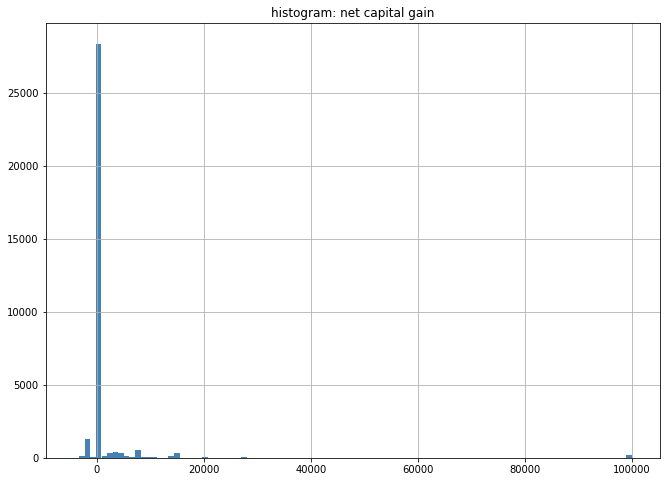

In [53]:
ax = table.capital_gain_net.hist(figsize=(11, 8), color="steelblue", bins=100)
ax.title.set_text("histogram: net capital gain")

I would like to zoom in on `capital_gain_net` where it's greater than 0. For this, I will use `loc`, which takes, unlike `iloc`, row and column _labels_. You can also pass a boolean mask for a row index:

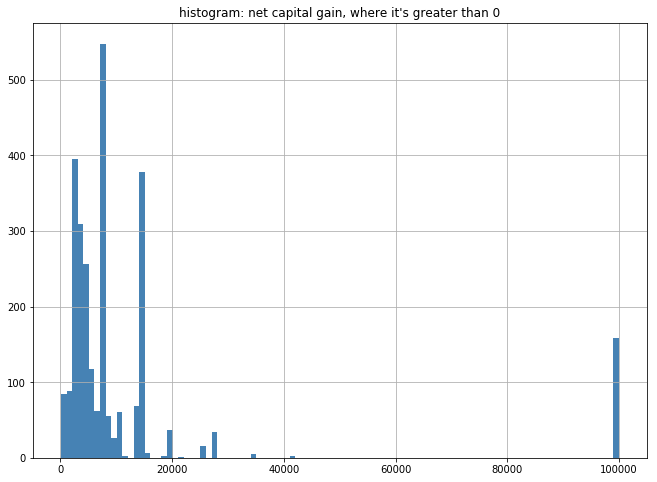

In [54]:
ax = table.loc[table.capital_gain_net > 0, "capital_gain_net"
              ].hist(figsize=(11, 8), 
                     color="steelblue", bins=100)

ax.title.set_text("histogram: net capital gain, where it's greater than 0")

Interesting, so, much like with `age`, we appear to have an artificial ceiling. It could be useful to engineer a column that simply indicates whether `capital_gain` is greater than 0:

In [55]:
table["is_capital_gain_nonzero"] = table.capital_gain.apply(lambda x: x > 0)

Let's take a similar look at `capital_loss`:

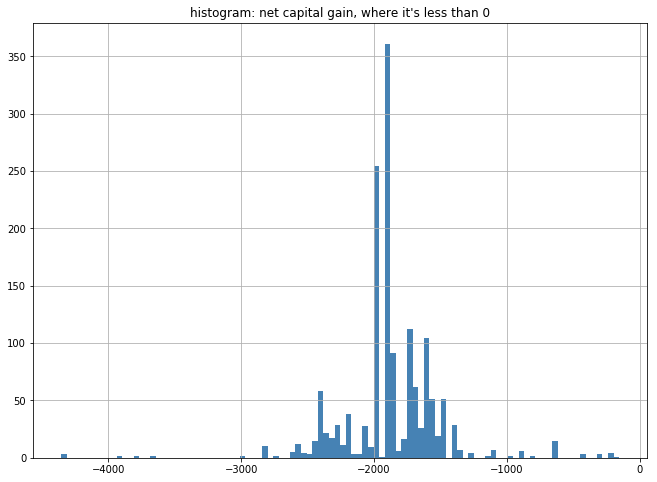

In [56]:
ax = table.loc[table.capital_gain_net < 0, "capital_gain_net"
              ].hist(figsize=(11, 8), 
                     color="steelblue", bins=100)

ax.title.set_text("histogram: net capital gain, where it's less than 0")

So, there's no obvious artificial floor here. But we're dealing with such a small portion of the data that a simple, boolean re-representation could prove useful:

In [57]:
table["is_capital_loss_nonzero"] = table.capital_loss.apply(lambda x: x < 0)

### Multivariate analysis - the _group by_

Anyone who's done SQL before knows how valuable the _group by_ can be. 

For those unfamiliar, the basic idea is that you take column of categorical data, and group another column of data around it. Or, put differently, you bucket the other column's data based on what values that row takes for the first column. And then you apply some sort of aggregation function. 

Let's look at an example. Here, we'll look at average `capital_gain` when income is over $50K vs. when it's not:

In [58]:
table[["over_fifty_k", "capital_gain"]].groupby("over_fifty_k").mean()

,capital_gain
over_fifty_k,
False,148.752468
True,4006.142456


Interesting, or maybe, not? Folks earning over $50K per year had, on average, much higher capital gains. 

Let's throw standard deviation into the mix. First, we'll save our previous result into a new variable (I'm prefixing the variable name with an underscore so as to avoid cluttering the namespace):

In [59]:
_cap_gains_means = table[["over_fifty_k", "capital_gain"]
                        ].groupby("over_fifty_k").mean()

Next, let's rename the column so as to avoid ambiguity:

In [60]:
_cap_gains_means.columns

Index(['capital_gain'], dtype='object')

In [61]:
_cap_gains_means = _cap_gains_means.rename(columns={"capital_gain": "capital_gain_mean"})

Note that we could have achieved the same result by running: `_cap_gains_means.columns = ["capital_gain_mean"]`

Next, let's create the standard deviation result:

In [62]:
_cap_gains_std = table[["over_fifty_k", "capital_gain"]
                        ].groupby("over_fifty_k").std()

In [63]:
_cap_gains_std = _cap_gains_std.rename(columns={"capital_gain": "capital_gain_std"})

Finally, we can _join_ these tables together. For those unfamiliar, this is another important SQL concept in which we, using a common column (in this case, the row index), concatenate the columns of two (or more) tables together.

In [64]:
_cap_gains_means.join(_cap_gains_std)

,capital_gain_mean,capital_gain_std
over_fifty_k,,
False,148.752468,963.139307
True,4006.142456,14570.378951


So, we have a much higher _average_ `capital_gain` with higher income, but also much more _volatility_. Let's quanitfy that on a relative basis.

In [65]:
_cap_gains_joined = _cap_gains_means.join(_cap_gains_std)

In [66]:
_cap_gains_joined["cap_gains_ratio"] = _cap_gains_joined.capital_gain_std / _cap_gains_joined.capital_gain_mean

In [67]:
_cap_gains_joined

,capital_gain_mean,capital_gain_std,cap_gains_ratio
over_fifty_k,,,
False,148.752468,963.139307,6.474779
True,4006.142456,14570.378951,3.637010


Interesting - _proportionately_, the low-income folks have more volatility. Do you think we could replicate this anlysis for our other numeric columns?

Now, before we do that ... based on our knowledge of the data, we've (hopefully) noticed that `education` and `education_num` are, for all intents and purposes, identical - so let's kill one from `table`:

In [68]:
table = table.drop("education_num", axis=1)

### Problem

Replicate the above group-by analysis, which we performed on `capital_gain`, on the other numeric columns in the data. Do this as programmatically as you can. Bonus points if you can figure out a way to measure the disparity between the results where `over_fifty_k` is `True`, and where it's `False`

In [69]:
def get_group_by_stats(df, col_to_group_by, col_to_group):
    means = df[[col_to_group_by, col_to_group]
               ].groupby(col_to_group_by).mean()
    
    means = means.rename(columns={col_to_group: f"{col_to_group}_mean"})
    
    stds = df[[col_to_group_by, col_to_group]
               ].groupby(col_to_group_by).std()
    
    stds = stds.rename(columns={col_to_group: f"{col_to_group}_std"})
    
    joined = means.join(stds)
    joined[f"{col_to_group}_ratio"] = joined[f"{col_to_group}_std"] / joined[f"{col_to_group}_mean"]
    
    return joined

In [70]:
get_group_by_stats(table, "over_fifty_k", "capital_gain")

,capital_gain_mean,capital_gain_std,capital_gain_ratio
over_fifty_k,,,
False,148.752468,963.139307,6.474779
True,4006.142456,14570.378951,3.637010


We can use a _list comprehension_ to programmatically generate a list of results for our columns:

In [71]:
_df_list = [get_group_by_stats(table, "over_fifty_k", col)
            for col in table.select_dtypes(include=[int, float]).columns]

We can then use the following trick to _efficiently_ combine these results (I'll also transpose results for viewability):

In [72]:
_df_list[0].join(_df_list[1:]).T

over_fifty_k,False,True
age_mean,36.783738,44.249841
age_std,14.020088,10.519028
age_ratio,0.381149,0.237719
fnlwgt_mean,190340.865170,188005.000000
fnlwgt_std,106482.271195,102541.775472
fnlwgt_ratio,0.559429,0.545420
capital_gain_mean,148.752468,4006.142456
capital_gain_std,963.139307,14570.378951
capital_gain_ratio,6.474779,3.637010
capital_loss_mean,53.142921,195.001530


Let's save these results:

In [73]:
_combined = _df_list[0].join(_df_list[1:]).T

In [74]:
_combined.columns

Index([False, True], dtype='object', name='over_fifty_k')

Notice that our column names are not strings, but the actual values `True` and `False`. Using _protected keywords_ like this can get you in to trouble, so let's map these to something safer:

In [75]:
_combined.columns = list(map(lambda x: str(x) + "_", _combined.columns))

Next, as a measure of disparity, let's calculate standard deviation across our columns:

In [76]:
_combined["std"] = _combined.std(axis=1)

It might make most sense to limit disparity across a certain measure, so let's filter our results down to mean aggregations:

In [77]:
_combined_filtered = _combined.loc[_combined.index.str.endswith("mean")]

Finally, we can sort by `std` and look at the top 10 values:

In [78]:
_combined_filtered.sort_values("std", ascending=False).iloc[:10]

,False_,True_,std
capital_gain_mean,148.752468,4006.142456,2727.586619
capital_gain_net_mean,95.609547,3811.140926,2627.277434
fnlwgt_mean,190340.865170,188005.000000,1651.706102
capital_loss_mean,53.142921,195.001530,100.309185
age_mean,36.783738,44.249841,5.279332
hours_per_week_mean,38.840210,45.473026,4.690109
age_log_mean,3.534742,3.761551,0.160378


So, at least _kind of_ cool, eh? You could go further here, for sure - pre-scaling these values down so that they're all within the same range would probably make this analyis more reliable. But the point is to show that one can actually get a whole lotta insight with just a bit of _analytical wrangling_, if you will - no machine learning required.

### Multivariate analysis - _cross tabulations_

Can we do something similar for categorical data?

In [79]:
pd.crosstab(table.over_fifty_k, table.marital_status).T

over_fifty_k,False,True
marital_status,,
Divorced,3980,463
Married-AF-spouse,13,10
Married-civ-spouse,8284,6692
Married-spouse-absent,384,34
Never-married,10192,491
Separated,959,66
Widowed,908,85


The `pd.crosstab` function allows us to break down data into groups, based on the values the passed rows take for each of two columns, and returns the count for each group.

Let's save these results:

In [80]:
_cross_tabs = pd.crosstab(table.over_fifty_k, table.marital_status).T

Get relative counts:

In [81]:
_cross_tabs = _cross_tabs / len(table)

Confirm our counts make sense:

In [82]:
_cross_tabs.sum().sum()

1.0

Visualize results:

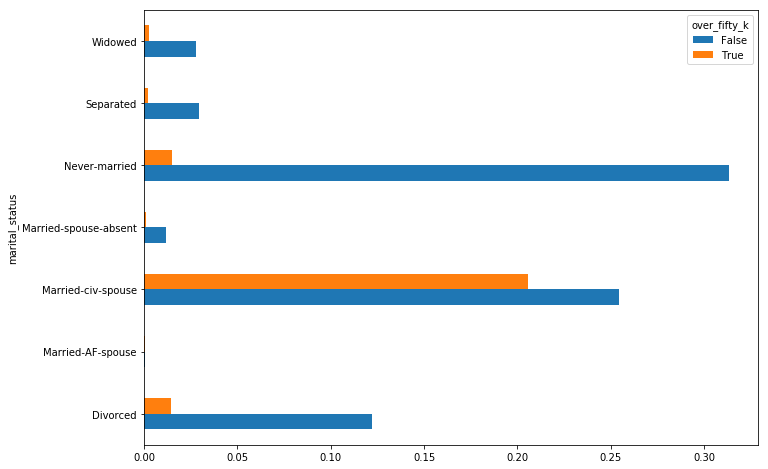

In [83]:
ax = _cross_tabs.plot.barh(figsize=(11, 8))

Can we go even further, tabulating more than two columns? In fact, we can:

In [84]:
table[["over_fifty_k", "marital_status", "sex"]
     ].groupby(["over_fifty_k", "marital_status", "sex"]
     ).size()

over_fifty_k  marital_status         sex   
False         Divorced               Female    2493
                                     Male      1487
              Married-AF-spouse      Female       8
                                     Male         5
              Married-civ-spouse     Female     903
                                     Male      7381
              Married-spouse-absent  Female     194
                                     Male       190
              Never-married          Female    4601
                                     Male      5591
              Separated              Female     614
                                     Male       345
              Widowed                Female     779
                                     Male       129
True          Divorced               Female     179
                                     Male       284
              Married-AF-spouse      Female       6
                                     Male         4
              Marrie

Look at that monstrosity! Can we make it make a little more sense? Let's save it and give it a name:

In [85]:
_multi_tab = table[["over_fifty_k", "marital_status", "sex"]
                     ].groupby(["over_fifty_k", "marital_status", "sex"]
                     ).size().rename("size")

Using the `unstack` method, we can pop one of our row-level breakdowns into a columnar breakdown:

In [86]:
_multi_tab.unstack()

sex                                 Female  Male
over_fifty_k marital_status                     
False        Divorced                 2493  1487
             Married-AF-spouse           8     5
             Married-civ-spouse        903  7381
             Married-spouse-absent     194   190
             Never-married            4601  5591
             Separated                 614   345
             Widowed                   779   129
True         Divorced                  179   284
             Married-AF-spouse           6     4
             Married-civ-spouse        754  5938
             Married-spouse-absent      11    23
             Never-married             166   325
             Separated                  17    49
             Widowed                    46    39

We can pick which level we pop out, too:

In [87]:
_multi_tab.unstack(0)

over_fifty_k                  False  True 
marital_status        sex                 
Divorced              Female   2493    179
                      Male     1487    284
Married-AF-spouse     Female      8      6
                      Male        5      4
Married-civ-spouse    Female    903    754
                      Male     7381   5938
Married-spouse-absent Female    194     11
                      Male      190     23
Never-married         Female   4601    166
                      Male     5591    325
Separated             Female    614     17
                      Male      345     49
Widowed               Female    779     46
                      Male      129     39

And if we'd like to pop it back in:

In [88]:
_multi_tab.unstack(0).stack()

marital_status         sex     over_fifty_k
Divorced               Female  False           2493
                               True             179
                       Male    False           1487
                               True             284
Married-AF-spouse      Female  False              8
                               True               6
                       Male    False              5
                               True               4
Married-civ-spouse     Female  False            903
                               True             754
                       Male    False           7381
                               True            5938
Married-spouse-absent  Female  False            194
                               True              11
                       Male    False            190
                               True              23
Never-married          Female  False           4601
                               True             166
                    

So, we could do this _all_ day (for many, many days...), but let's move on to feature selection. Before we go...

### Problem

Think about the analyses we've performed and whether you wish we'd given any of them more time. Think about some more columns you might engineer out of the data we've got, and add _at least two_ new columns to `table`.

# 3. Feature Selection

Choosing the right set of features can bring many benefits.

Some models don't work well with redundancy, so you'll want to choose features that are not too inter-related. Sometimes you'll _want_ to over-emphasize features that are particularly important, or create additional relationships between features whose sum are greater than their parts, in the figurative sense.

Additionally, some datasets contain many, many columns, and reducing the amount of inputs to your model can drastically reduce the time it takes to prep your data and train your model. 

The benefits go on. In this case, we have a pretty simple feature set, but it will still help us to get a sense of what's the most predictive, what has the most overlap with what we've already got, etc.

It should be noted that, when developing predictive models, you always need to be careful to _not base your performance benchmarks off of what you're training your models on_, and that goes even for feature selection - it's one thing to look at the entire dataset when you're exploring and looking for problems, but it's another to be programmatically making decisions around what to include in a model.

So we will start by taking 10% of our data out and putting on the back burner - only for use at the _very_ end, once we've already _decided_ what our model and feature set are. We will take this 10% out _randomly_ and with respect to the _natural stratification_ of our target's (what we're trying to predict - `over_fifty_k`) classes (`True`, `False`).

In [89]:
train_inds, test_inds = train_test_split(
    table.index, test_size=.1, stratify=table.over_fifty_k)

In [90]:
table_train = table.loc[train_inds, 
            [c for c in table.columns if c != "over_fifty_k"]]

In [91]:
fifty_k_train = table.loc[train_inds, "over_fifty_k"]

### Feature redundancy

Let's start with looking at feature redundancy. There are many ways to do this, and one thing I did recently was to leverage _Euclidean distance_, which, between two vectors $p$ and $q$ is $\sqrt{ \sum_{i}^n (q_{i} - p_{i})^2}$

See more [here](https://en.wikipedia.org/wiki/Euclidean_distance). 

I wrote my own function for this recently, and I thought we could try it out, even if only for conceptual purposes. The way this function works is: you pass it a DataFrame, and a selection of columns, and it computes pairwise distances between all the columns:

In [94]:
euclideans = wrangle.euclidean_distances(table_train, 
                                         table_train.select_dtypes(include=[int, float, bool]).columns)

In [95]:
euclideans.shape

(36, 1)

In [96]:
euclideans.describe()

,euclidean_distances
count,36.000000
mean,49.384305
std,23.513653
min,6.974706
25%,26.333037
50%,50.853531
75%,69.746311
max,85.967754


Since we have a bit of dispersion here, let's take a cut of the results a bit above the mean and take everything below that:

In [97]:
euclideans[euclideans.euclidean_distances < 60]

euclidean_distances
feature_one             feature_two                                 
age                     is_capital_loss_nonzero            59.799152
                        capital_gain                       59.082216
                        capital_loss                       58.575348
fnlwgt                  hours_per_week                     54.371493
age                     capital_gain_net                   53.453675
capital_loss            is_capital_gain_nonzero            52.149016
is_capital_gain_nonzero is_capital_loss_nonzero            49.558047
fnlwgt                  is_capital_gain_nonzero            49.457485
age                     fnlwgt                             46.099179
capital_gain            is_capital_gain_nonzero            44.555005
capital_gain_net        is_capital_gain_nonzero            43.221133
age                     hours_per_week                     41.575635
hours_per_week          age_log                            41.032776
age                     age_log                            28.360136
fnlwgt                  capital_loss                       26.504865
                        capital_gain                       25.817554
                        is_capital_loss_nonzero            24.011659
capital_loss            capital_gain_net                   21.556189
fnlwgt                  capital_gain_net                   21.020020
capital_gain            capital_loss                       20.748236
capital_loss            is_capital_loss_nonzero            16.233294
capital_gain_net        is_capital_loss_nonzero            15.109621
capital_gain            is_capital_loss_nonzero            12.921666
                        capital_gain_net                    6.974706

Let's get a nice, pairwise view of everything under 50:

In [98]:
list(euclideans[euclideans.euclidean_distances < 50].index)

[('is_capital_gain_nonzero', 'is_capital_loss_nonzero'),
 ('fnlwgt', 'is_capital_gain_nonzero'),
 ('age', 'fnlwgt'),
 ('capital_gain', 'is_capital_gain_nonzero'),
 ('capital_gain_net', 'is_capital_gain_nonzero'),
 ('age', 'hours_per_week'),
 ('hours_per_week', 'age_log'),
 ('age', 'age_log'),
 ('fnlwgt', 'capital_loss'),
 ('fnlwgt', 'capital_gain'),
 ('fnlwgt', 'is_capital_loss_nonzero'),
 ('capital_loss', 'capital_gain_net'),
 ('fnlwgt', 'capital_gain_net'),
 ('capital_gain', 'capital_loss'),
 ('capital_loss', 'is_capital_loss_nonzero'),
 ('capital_gain_net', 'is_capital_loss_nonzero'),
 ('capital_gain', 'is_capital_loss_nonzero'),
 ('capital_gain', 'capital_gain_net')]

Based on this analysis, I'd definitely consider killing:
- `capital_gain`
- `capital_loss`
- either `age` or `age_log`
- the boolean re-representations of `capital_loss`
- `fnlwgt`

Interestingly, `capital_gain` and `is_capital_gain_nonzero` were only about average in their differences.

`fnlwgt` is a statistical demographic measure, so it obviously shows up as related to a number of features. It seems close enough to `capital_gain_net` that I would kill it for now, especially since we don't really know what it is ;)

We can always add these columns back in later.

In [99]:
table_train = table_train.drop(["capital_gain", "capital_loss", "age_log",
                               "is_capital_loss_nonzero", "fnlwgt"], axis=1)

### Feature Selection

Now, let's get into picking the _good_ features. 

To do this, we're going to need to do a little data prep. This data prep entails _one-hot_ (or _dummy_) encoding our `object` columns. 

What this type of encoding does is take a single column of categorical data and convert it into a number of columns - as many columns as there are values for the categorical variable - with only boolean values, representing whether or not a given row takes a particular categorical value.

Let's look at an example:

In [100]:
table_train.sex.head()

1327     Female
14881      Male
28458      Male
29641    Female
3779       Male
Name: sex, dtype: object

In [101]:
pd.get_dummies(table_train.sex.head())

,Female,Male
1327,1,0
14881,0,1
28458,0,1
29641,1,0
3779,0,1


So instead of five rows, each containing `"Female`" or `"Male"` we now have five rows, each containing a `1` in the `Male` and `0` in the `Female` column if `sex="Male"`, or v.v. if  `sex="Female"`.

Note that there does not have to be mutual exclusivity between the columns that result from a one-hot encoding. If there _is_ mutual exlusivity, it is good practice to drop one of your resulting columns, lest you introduce some redundancy into your feature set. E.g. we wouldn't want to represent `over_fifty_k` with two columns `over_fifty_k` and `equal_to_or_under_fifty_k`, right?

In this case, we're going to quickly iterate through each `object` column, perform the encoding, and drop one of the resulting columns, for the sake of brevity (rather than really think on each column). We're also going to prefix each of our resulting columns with the name of the column that the value originall came from, to avoid possible name collisions:

In [102]:
_one_hots = [pd.get_dummies(
                table_train[col], drop_first=True, prefix=col)
             for col in table_train.select_dtypes(include=object
                                                 ).columns]

In [103]:
_one_hots[0].iloc[:3, :3]

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked
1327,0,0,0
14881,0,0,0
28458,0,0,0


In [104]:
one_hot_df = _one_hots[0].join(_one_hots[1:])

In [105]:
one_hot_df.shape

(29304, 94)

Now we can create our $X$ and $y$:

In [110]:
X = one_hot_df.join(table_train.select_dtypes(
                        include=[int, float, bool]))

In [111]:
X.shape

(29304, 98)

In [112]:
table_train.dtypes.value_counts()

object    8
int64     3
bool      1
dtype: int64

In [113]:
y = fifty_k_train

Next, we're going to create a _Random Forest Classifier_. What's that mean? Let's break it down.

A _Decision Tree_ is a model that builds a series of rules, kind of like the game _twenty questions_. E.g is `age` >= 15? It typically does this repeatedly until it either:
- has created a number of _pure_ (or close to it) "leaves" such that a given data point can be propogated through the tree and to a point where only data of a certain label or value would get it
- it hits some internal cutoff around tree depth or the number of items that make it to a leaf

So what's a _Random Forest_, then? You build a whole bunch of decision trees, such that each tree is a little bit different, and take the average across all these tree's votes to produce your final prediction. Why do you do this? To prevent something called _overfitting_. Overfitting occurs when a model has coupled itself so tightly to the data it was trained on that it loses its ability to generalize to new data.

It's worth noting that random forests are models for which it's desirability to limit redundancy in your features, as redundant features will limit the effectiveness of creating a number of different trees.

So, what's a Random Forest _Classifier_, then? A classifier is just a model that predicts a class or label, as opposed to a numerical value - i.e. it's built for predicting categorical values.

We'll also set this forest to build 10 trees (in practice, it's generally good to use 100), and pass another argument for `class_weight`, which we'll get to in a bit:

In [114]:
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

Now, we'll use something called the _recursive feature eliminator_, which will repeatedly check for the weakest feature in the model and eliminate it from use, and will repeat this process _recursively_ until it's hit the number of features you've asked it to find:

In [115]:
selector = RFE(rf, 10)

In [116]:
selector.fit(X, y)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
  n_features_to_select=10, step=1, verbose=0)

These are the top 10 columns that were selected:

In [117]:
sorted(list(X.columns[selector.support_]))

['age',
 'capital_gain_net',
 'education_Bachelors',
 'hours_per_week',
 'marital_status_Married-civ-spouse',
 'marital_status_Never-married',
 'occupation_Exec-managerial',
 'occupation_Prof-specialty',
 'relationship_Not-in-family',
 'sex_Male']

In [118]:
ranks = pd.DataFrame(
    list(zip(X.columns, selector.ranking_)), 
    columns=["column_name", "rank_survived_until"]
                     ).sort_values("rank_survived_until")

Let's look at the next 10:

In [119]:
ranks.iloc[10:20]

,column_name,rank_survived_until
97,is_capital_gain_nonzero,2
19,education_Masters,3
3,workclass_Private,4
18,education_HS-grad,5
51,race_White,6
22,education_Some-college,7
36,occupation_Other-service,8
46,relationship_Unmarried,9
91,native_country_United-States,10
40,occupation_Sales,11


Let's look at the 10 worst:

In [120]:
ranks.iloc[-10:]

,column_name,rank_survived_until
90,native_country_Trinadad&Tobago,80
77,native_country_Laos,81
80,native_country_Outlying-US(Guam-USVI-etc),82
86,native_country_Scotland,83
7,workclass_Without-pay,84
89,native_country_Thailand,85
30,occupation_Armed-Forces,86
68,native_country_Honduras,87
2,workclass_Never-worked,88
67,native_country_Holand-Netherlands,89


Let's retain these particularly bad ones:

In [121]:
crummy_features = ranks.iloc[-10:].index

### Problem

Pick another methodology - and feel free to use Google, your instincts, or whatever you please - to devise a methodology to select features. Then, go ahead and try it out!

I'm going to go with building a Random Forest on the entire data set, and looking at which features rank as the most _important_ (i.e. how good they are at sorting the data based on `over_fifty_k`). This is actually not so dissimilar to what we did above - simpler, a bit quicker, a different kind of thoroughness.

In [122]:
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

Now, let's fit our model to our data:

In [123]:
rf = rf.fit(X, y)

In [124]:
importances = pd.DataFrame(list(zip(X.columns, rf.feature_importances_)), 
                           columns=["column_name", "importance"])

In [125]:
importances.sort_values("importance", ascending=False
                       ).iloc[:10
                       ].sort_values("column_name")

,column_name,importance
94,age,0.256010
96,capital_gain_net,0.086196
16,education_Bachelors,0.020908
95,hours_per_week,0.109630
97,is_capital_gain_nonzero,0.019129
24,marital_status_Married-civ-spouse,0.061139
26,marital_status_Never-married,0.061121
43,relationship_Not-in-family,0.031130
45,relationship_Own-child,0.036966
46,relationship_Unmarried,0.023280


Aaaannnd we see a very similar set of features :)

We other method, we are are attempting to find the best possible features by recursively re-train the model with an ever-better set of features. With this method, we are training the model once and looking for the strongest features (and can very granularly quantify what _strongest_ means).

One reason for these two results being _exactly_ the same, i.e. more than just very similar, could be the fact that we have asked `RFE` for the 10 best features and, based on the default behavior of the `RandomForestClassifier`, the forest is likely considering about 10 features every time it gets to make a split. 

However, "weeds" stuff aside, the fact that these two methods have returned the same features mean that these 10 are likely our top features - or at the least, they're very useful.

In [126]:
X.shape

(29304, 98)

# 3. Machine Learning

Let's build a model, and let's evaluate it (at least somewhat) properly.

### Class imblanace

One thing I cannot stress enough is the need to keep in mind the balance of your classes in the data you have. For example, let's say I start with the following model.

In [127]:
def crummy_model(X):
    return np.zeros((len(X),))

In [128]:
y_pred = crummy_model(X)

In [130]:
accuracy_score(y, y_pred)

0.7591796341796342

What?! All we did we literally return 0 for every value! And now you've seen the danger of class imblanace - when you more of one class than the other, if you always pick the _majority_ class, you'll have a model that looks decent (or at least, better than it is not).

This is what the `class_imblanace` argument is for - it tells the forest to build each tree based off a _class-balanced_ subset of the data.

### Scores

So, how do protect ourselves, aside from setting the right model parameters, against falling into that sort of trap?

The above example showed that _accuracy_, though a nice thumb-in-the-air sort of metric, and also a metric that lots of managers will enjoy discussing, can be pretty dangerous to use. There are better scores, for sure, but one thing you can always do with your prediction results is _look_ at them, rather than just roll them up into a score.

In [131]:
def get_confusion(y, y_true):
    matrix = confusion_matrix(y, y_true)
    
    df = pd.DataFrame(matrix,
                     index=["negative_actual", "positive_actual"],
                     columns=["negative_predicted", "positive_predicted"])
    
    return df

In [132]:
get_confusion(y, y_pred)

,negative_predicted,positive_predicted
negative_actual,22247,0
positive_actual,7057,0


Enter the _confusion matrix_, whose rows represent the _actual class value_ and whose columns represent the _predicted class value_. Looking at the above, we can see clearly that _all_ our model did was predict `negative`.

A little bit more on the confusion matrix: the diagonal (i.e. positions `(0,0)` and `(1, 1)`) hold the correct predictions. Points falsely predicted as positive are known as _false positives (FP)_, and points correctly predicted as positive are known as _true positives (TP)_ - the same nomenclature holds on the negative side.

We can get _accuracy_ score from the above through taking the following ratio:
- $ \large \frac {TP + TN}{TP + TN + FP + FN}$

But we can get some more nuanced measures here, too. If the above is our overall accuracy, what if we broke that down into two, let's say this colloquially, components? For instance:
1. a model's carefulness
2. a model's thoroughness

How might we calculate these scores? 

Maybe for carefulness, we could do:
1. $\large \frac{TP}{TP + FP}$
The above is the ratio of correct, positive predictions to the number of _total_positive predictions_ - i.e. of all the times the model predicted _positive_, what proportion of those predictions were correct?

Maybe for thoroughness, we could do:
2. $\large \frac{TP}{TP + FN}$
The above is the ratio of correct, positive predictions to the number of _total actual positive values_ - i.e. out of all the actual positive values in the data, what proportion did the model correctly identify?

It turns out that 1 and 2 are in fact real, well-known scores, referred to formally as **precision** and **recall**, respectively. Which you might use depends on what you trying to solve for, and what the consequences of different types of mistakes are.

It's almost like different styles of poker players - some bet carefully, preserving their bankroll, while some bet aggressively, not wanting to miss an opptortunity to make money. Or, for another example, it could be like talking to people at a cocktail party - do you want to speak only to people who you think have a good chance of responding to you, or do you want to speak to as many people as possible?

Often times, it's somewhere in the middle, and there a whole bunch of other scores one could look to for help in evaluating a predictive model, especially as one goes behind the _class labels_ and into the _class probabilities_. For now, these 3 scores + the confusion matrix, should provide a great starting point.

### Cross-validation

So how do we actually evaulate our models? We generally pick some kind of scoring metric, and then run several trials using different samplings of the data, and use the highest aggregate (usually through taking the _mean_) score across these trials as an indiciation of us having found the best model (it can help to think of _deviation_ throughout the trials, too).

The key to this process is _cross-validation_. In cross-validation, we break the data into chunks - for the sake of example, let's say 5. We take 4 of those chunks and use them to train a model, and test that model on the _other_ chunk, and retain that score value. Then, you repeat that process, taking your previous test chunk back into the train set, and taking a different train chunk out for the test set. You do this until you've tested on all 5 chunks and then typically report the average (and maybe standard deviation) across these trials.

This achieves two main things:
- you get to evaluate your model's performance on different chunks of the data
- you avoid evaluating the model's results on the data you've trained it on

Let's try this out.

Build a model:

In [133]:
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

Accuracy:

In [134]:
accs = cross_val_score(rf, X, y, 
                       scoring=make_scorer(accuracy_score), cv=5)

In [135]:
np.mean(accs), np.std(accs)

(0.8391006808471989, 0.002863262842660567)

Precision:

In [136]:
precs = cross_val_score(rf, X, y, 
                        scoring=make_scorer(precision_score), cv=5)

In [137]:
np.mean(precs), np.std(precs)

(0.6882051823466857, 0.008918218266457402)

Recall:

In [138]:
recs = cross_val_score(rf, X, y, 
                       scoring=make_scorer(recall_score), cv=5)

In [139]:
np.mean(recs), np.std(recs)

(0.6086132230973552, 0.015201257513117307)

### Hyper-parameter tuning

An obvious goal when selecting the model is to avoid _underfitting_ - i.e. we want our model to fit the data well. But, as mentioned before, we also want to avoid _overfitting_, or coupling our selves to tightly to the data we train on.

We evaluate this by comparing our _train scores_ to the _test scores_. If there's a large disparity - let's say, greater than 5% - than we are likely overfitting. How do we handle that? Most models have some _hyper-parameters_ - parameters you pass the model creation process, as opposed to the data that you pass to the model fitting proces - that will limit a model's growth. 

With _logistic regression_, you can control regularization - forcing a model's coefficients to stay near 0, or even allowing some coefficients to drop out. With a _random forest_, you can control the depth of a tree, and how small the final leaf nodes can get.

In [140]:
results = cross_validate(rf, X, y, 
                         scoring=make_scorer(recall_score), 
                         cv=5, return_train_score=True)

In [141]:
results_train = pd.Series(results["train_score"], name="train")

In [142]:
results_test= pd.Series(results["test_score"], name="test")

In [143]:
results_train.to_frame().join(results_test)

,train,test
0,0.937467,0.584986
1,0.934455,0.629603
2,0.939249,0.601701
3,0.939603,0.574770
4,0.938718,0.615875


We can see quite a disparity here! I wonder what will happen if we limit tree depth?

In [144]:
rf_depth = RandomForestClassifier(n_estimators=10, 
                                  class_weight="balanced", 
                                  max_depth=16)

In [145]:
results = cross_validate(rf_depth, X, y, scoring=make_scorer(recall_score), cv=5, return_train_score=True)

In [146]:
results_train = pd.Series(results["train_score"], name="train")

In [147]:
results_test= pd.Series(results["test_score"], name="test")

In [148]:
results_train.to_frame().join(results_test)

,train,test
0,0.912489,0.832861
1,0.921169,0.864731
2,0.912504,0.839830
3,0.914098,0.827073
4,0.920298,0.863926


Wow - a big difference! By the way, if we wanted to evaluate based on limiting the size of the leaves in the trees, you could tweak the `min_samples_leaf` hyper-parameter.

A good tecnhique is to evaluate a model's performance over different hyper-parameter values. `sklearn` has implemented something called `GridSearchCV`, which will perform an exhaustive search over the different parameter values you pass. This is a great tool, and makes setting up automated build pipelines much easier.

However, in analysis stage, I like to _look_ at results. I've wrapped some of the `sklearn` functionality with `matplotlib` code to allow for visualizing your CV over different hyper-parameter values.

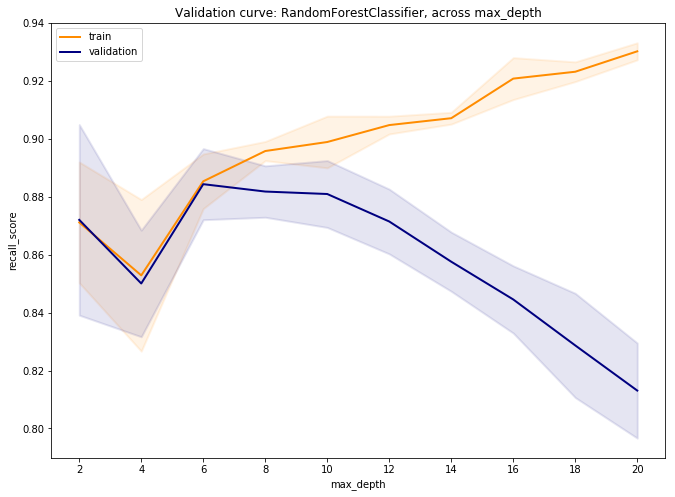

In [149]:
curves.validation_curve(X, y,
                        score=recall_score,
                        model_type=RandomForestClassifier,
                        param_name="max_depth",
                        param_range=[2*n for n in range(1, 11)],
                        other_params={"n_estimators": 10, 
                                      "class_weight": "balanced"})

Here we can see the overfitting quite clearly - look how the train and test scores separate as tree depth increases!

### Why I like Random Forests

There are many models to choose from, with each providing their own strengths and weaknesses.

Simpler models lead to reduced odds of overfitting, quicker build times, and easier debugging when problems occur. For example, _logistic regression_, which basically entials wrapping a linear regression model with the _logit_ function, which squashes output to between 0 and 1, is considered a very simple model (bonus: it naturally produces great probabilities).

Complex models bring the burdens of potential overfitting, more hyperparameters to tune, longer train times, etc. But they can sometimes deliver much stronger results (see: the world of neural networks).

Often times it comes down to what's known as the _bias-variance trade-off_: would you rather have your model be wrong, but conistent? Or sometimes very right, and sometimes very wrong? Generally, it's somewhere in between.

Now, data preparation plays a part, too. With any model that involves taking a linear combination of feautes (e.g. logistic regression, or the internals of a multi-layer perceptron), pre-treating your continuous data so that its values are _normalized_ (between 0 and 1) is very important. So is reducing skewness. Additionally, you must worry about outliers. And of course, missing data...

With a random forest, you do not need to worry about feature scaling or skewness. You also don't need to worry about outliers (since the tree works through _splitting_, and not multiplying and adding). Ditto for missing data, as long as you encode it correctly.

So, RF models take some of the fun out creative data prep, but they also make it very straightforward to get going.

### Problem

Your turn - find the "best" model you can. This means you need to:
- pick a score function to use
- pick a subset of the feature space to use
- pick the model hyper-parameters to use

Try out different combinations of features to see if you get anything that's noticeably better. For those of you who have done this before, please feel free to try additional models.

### Final performance estimation

Once we've done _everything_ we'd like to do for our model evaulation, we can use our selected model to predict the _hold-out_ set that we saved earlier.

In [217]:
table_test = table.loc[test_inds, [c for c in table.columns if c != "over_fifty_k"]]

In [218]:
fifty_k_test = table.loc[test_inds, "over_fifty_k"]

In [219]:
table_test = table_test.drop(["capital_gain", "capital_loss", "age_log",
                               "is_capital_loss_nonzero", "fnlwgt"], axis=1)

In [220]:
_one_hots = [pd.get_dummies(table_test[col], drop_first=True, prefix=col)
             for col in table_test.select_dtypes(include=object).columns]

In [221]:
one_hot_df_test = _one_hots[0].join(_one_hots[1:])

In [222]:
one_hot_df_test.shape

(3257, 89)

In [223]:
X_test = one_hot_df_test.join(table_test.select_dtypes(include=[int, float]))

In [225]:
X_test.shape

(3257, 92)

In [227]:
table_test.dtypes.value_counts()

object    8
int64     3
bool      1
dtype: int64

In [229]:
y_test = fifty_k_test